In [167]:
from copy import copy, deepcopy
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor  
import random

import sklearn.linear_model
import pandas as pd 
import numpy as np
import sys
import re

%matplotlib inline

In [168]:
# Load the Wine Dataset
df_wine = pd.read_csv("df_wine.csv", encoding = 'utf8', index_col=0)

In [169]:
df_wine.head(1)

,price,title,points,year_of_wine,v_Abouriou,v_Aglianico,v_Airen,v_Albana,v_Albanello,v_Albariño,...,province_Spanish Islands,province_Tasmania,province_Texas,province_Tuscany,province_Veneto,province_Vermont,province_Victoria,province_Virginia,province_Washington,province_Western Australia
0,14.0,Rainstorm 2013 Pinot Gris (Willamette Valley),87,2013,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data Preparition

In [170]:
# DEFINE X and Y VARIABLES
df_wine = df_wine[df_wine['year_of_wine'] > 0]
df_X = df_wine.drop('points', axis=1)
df_X = df_X.drop('title', axis=1) # year was already extracted
df_Y = df_wine[['points']]

# Test & Train Split

In [171]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.3, random_state=0) 

# HPO with ground truth

In [ ]:
# Using Randomized Search instead of a grid search

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
regressor3 = DecisionTreeRegressor()
param_dist = {'max_depth': sp_randint(2,16),
              'min_samples_split': sp_randint(2,16)}

n_iter_search = 20
clfrs = RandomizedSearchCV(regressor3, 
                                   param_distributions=param_dist,
                                   scoring='neg_mean_squared_error',
                                   cv=5 , n_jobs=1, verbose=1,
                                   n_iter=n_iter_search)
clfrs.fit(df_X, df_Y)
clfrs.best_params_, clfrs.best_score_

# Decision Tree

In [66]:
# Best result with Hyperparameter optimisation
regressor = DecisionTreeRegressor(max_depth=10, min_samples_split=10)  

# Train the model using the training sets
regressor.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regressor.predict(X_test)

# The evaluation metrics
from sklearn import metrics  
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

Mean Absolute Error: 1.8540062342504866
Mean Squared Error: 5.511431720382069
Root Mean Squared Error: 2.347643865747543


# Introduce Errors in Training

In [172]:
# Ground truth for other calculations
X_train_gt = X_train.copy()

In [173]:
X_train[['year_of_wine']].describe()

,year_of_wine
count,68389.000000
mean,2010.658205
std,3.598446
min,1945.000000
25%,2009.000000
50%,2011.000000
75%,2013.000000
max,2017.000000


In [174]:
year = X_train[['year_of_wine']].copy()
year.columns = ['new_year']
# df_wine = pd.concat([year, df_wine], axis=1)
# df_wine

In [175]:
def introduce_outliers(df):
    rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]
    # minimum sayi 1940 %0.5 e kadar artabilir
    # max sayi 2018 %0.5 e kadar artabilir
    j = 0
    year_val = 0
    for i, row in df.iterrows():
        if j%2 == 0:
            year_val = row['year_of_wine'] * random.choice(rates) 
            df.at[i,'year_of_wine'] = year_val
        j = j + 1
    return df

In [176]:
X_train = introduce_outliers(X_train)

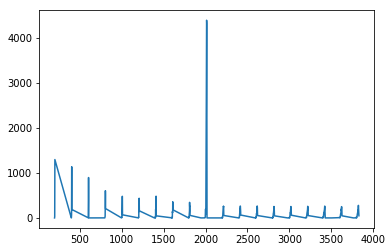

In [177]:
plt.plot(X_train.groupby(['year_of_wine']).size())

# Precision & Recall

In [161]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(X_train_gt['year_of_wine'].values, X_train['year_of_wine'].values, average='weighted')

(0.9998391554197312, 0.49999268888271503, 0.6665894119163277, None)

# HPO with Errors in Training

In [63]:
# Using Randomized Search instead of a grid search

# combine training and testing
tr_data = pd.concat([X_train, X_test], axis=0)
te_data = pd.concat([y_train, y_test], axis=0)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
regressor3 = DecisionTreeRegressor()
param_dist = {'max_depth': sp_randint(2,16),
              'min_samples_split': sp_randint(2,16)}

n_iter_search = 20
clfrs = RandomizedSearchCV(regressor3, 
                                   param_distributions=param_dist,
                                   scoring='neg_mean_squared_error',
                                   cv=5 , n_jobs=1, verbose=1,
                                   n_iter=n_iter_search)
clfrs.fit(tr_data, te_data)
clfrs.best_params_, clfrs.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.9min finished


({'max_depth': 10, 'min_samples_split': 12}, -5.597307235191265)

# Decision Tree Regressor with Outliers in Training

In [64]:
# Best result with Hyperparameter optimisation
regressor = DecisionTreeRegressor(max_depth=10, min_samples_split=12)  

# Train the model using the training sets
regressor.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regressor.predict(X_test)

# The evaluation metrics
from sklearn import metrics  
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

Mean Absolute Error: 1.8539466635089954
Mean Squared Error: 5.511124910267278
Root Mean Squared Error: 2.3475785205754627


# Outlier Detection

In [180]:
mean = np.mean(X_train[['year_of_wine']], axis=0)
sd = np.std(X_train[['year_of_wine']], axis=0)

In [181]:
def outlier_detection(data):
    mean = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    final_list = [x for x in data if (x > mean - 2 * sd)]
    final_list = [x for x in final_list if (x < mean + 2 * sd)]
    return final_list, mean

In [182]:
year_outliers = outlier_detection(X_train['year_of_wine'].values)[0]
mean = outlier_detection(X_train['year_of_wine'].values)[1]

In [187]:
min_year = min(year_outliers)
max_year = max(year_outliers)

training_data = pd.concat([X_train, y_train], axis=1)

# DROP
# training_cleaned = training_data.drop(training_data[training_data.year_of_wine < min_year].index)
# training_cleaned = training_cleaned.drop(training_cleaned[training_cleaned.year_of_wine > max_year].index)
# X_train_outlier_cleaned = training_cleaned[training_cleaned.columns[:-1].tolist()]
# y_train_outlier_cleaned = training_cleaned.filter(['points'], axis=1)

# MEAN
training_data.loc[training_data['year_of_wine'] < min_year, 'year_of_wine'] = round(mean)
training_data.loc[training_data['year_of_wine'] > max_year, 'year_of_wine'] = round(mean)
X_train_outlier_cleaned = training_data[training_data.columns[:-1].tolist()]
y_train_outlier_cleaned = training_data.filter(['points'], axis=1)

# PRECISION & RECALL & RMSE FOR ERRORS

In [189]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(X_train_gt['year_of_wine'].values, X_train_outlier_cleaned['year_of_wine'].values, average='weighted')

(0.9947509054399267, 0.5003143780432525, 0.6633452708010935, None)

In [190]:
# RMSE for Cleaned data and GT
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(X_train_gt['year_of_wine'].values, X_train_outlier_cleaned['year_of_wine'].values))) 

Root Mean Squared Error: 625.5894925408817


In [191]:
# RMSE for Dirty data and GY
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(X_train_gt['year_of_wine'].values, X_train['year_of_wine'].values))) 

Root Mean Squared Error: 800.9942547920783


# HPO optimisation with Clened Data

In [82]:
# Using Randomized Search instead of a grid search

# combine training and testing
tr_data = pd.concat([X_train_outlier_cleaned, X_test], axis=0)
te_data = pd.concat([y_train_outlier_cleaned, y_test], axis=0)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
regressor3 = DecisionTreeRegressor()
param_dist = {'max_depth': sp_randint(2,16),
              'min_samples_split': sp_randint(2,16)}

n_iter_search = 20
clfrs = RandomizedSearchCV(regressor3, 
                                   param_distributions=param_dist,
                                   scoring='neg_mean_squared_error',
                                   cv=5 , n_jobs=1, verbose=1,
                                   n_iter=n_iter_search)
clfrs.fit(tr_data, te_data)
clfrs.best_params_, clfrs.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.5min finished


({'max_depth': 9, 'min_samples_split': 15}, -5.590351375101802)

# Decision Tree Regressor with Cleaned Data

In [83]:
# Best result with Hyperparameter optimisation
regressor = DecisionTreeRegressor(max_depth=9, min_samples_split=15)  

# Train the model using the training sets
regressor.fit(X_train_outlier_cleaned, y_train_outlier_cleaned)

# Make predictions using the testing set
y_pred = regressor.predict(X_test)

# The evaluation metrics
from sklearn import metrics  
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

Mean Absolute Error: 1.8486854262898185
Mean Squared Error: 5.493019810291517
Root Mean Squared Error: 2.3437192259934885
